<a href="https://colab.research.google.com/github/tarjerw/TDT4173-project-group6/blob/main/ML_project_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Political party analysis program that parses the tweets fetched from Twitter using Python

In [ ]:
###### IMPORT THE LIBRARIES  #########
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime

#sklearn, used for train_test_split
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



#used for data cleaning
import re
import string

#used nltk used for sopwords and tokenizing
import nltk
nltk.download('punkt')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords


#gensim is used to help create the Word2Vec model used
import gensim.models
from gensim.models import Word2Vec, KeyedVectors
from gensim import models

import io

#keras is used for creating the CNN 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.models import Model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Retrieve data

In [ ]:
#retrieves data
tweets2016_df = pd.read_csv('TweetDatabase_2016.csv')
tweets2020_df = pd.read_csv('TweetDatabase_2020.csv')
tweets2016_2020_df = tweets2016_df.append(tweets2020_df)
df_all = tweets2016_2020_df #set which dataset to use (2016 or 2020,or both)
df_all = df_all.drop_duplicates() #removes all duplicates
#shuffles data
df_all = df_all.sample(frac = 1)

#Sentiment Analysis using Convolution Neural Networks



> Create word2vec model




In [ ]:
#this might take some time, 4 min
#creating a word2vec model using reddit world news dataset, which can be accessed here: https://www.kaggle.com/rootuser/worldnews-on-reddit

reddit_df = pd.read_csv('reddit_worldnews_start_to_2016-11-22.csv') #https://www.kaggle.com/rootuser/worldnews-on-reddit
# Dataset is now stored in a Pandas Dataframe 

#make all words lowercase, as all words in tweets are converted to lowercase 
reddit_df['title'] = reddit_df['title'].str.lower()

newsTitles  = reddit_df['title'].values
tweets2016 = tweets2016_df['Tweet'].values
tweets2020 = tweets2020_df['Tweet'].values
newsTitles = np.concatenate((newsTitles, tweets2016, tweets2020), axis=0) #add tweets data for training the word2vec model
newsVec = [nltk.word_tokenize(title) for title in newsTitles]

word2vec_dim = 350 #sets the dimension of the vector for each word

word2vec = Word2Vec(newsVec,min_count=1,size= word2vec_dim) #creating the word2vec model, using gensim.Word2Vec function with the data from the reddit_worldnews dataset
#this model can be used for converting words to vectors! :) 

#prints timestamp of when last completed
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Last updated at =", current_time, "word2vec_dim set to:", word2vec_dim)

KeyboardInterrupt: ignored

Clean Data, and tokenize

In [ ]:
#data cleaning 

#removes punctuation for all words
def nopunct(inputString):
    nopunct = ''
    nopunct = re.sub('['+string.punctuation+']', '', inputString)
    return nopunct
    

df_all['Clean_Tweet'] = df_all['Tweet'].apply(lambda x: nopunct(x))

#use NLTK’s word_tokenize, which turns sentences into list of words(tokens). e.g, "hello world" -> ["hello","world"]
tokens = [word_tokenize(tweet) for tweet in df_all.Clean_Tweet]

#set all words to lower case
def lword(tweet): 
    return [t.lower() for t in tweet]     
lower_tweet = [lword(tweet) for tweet in tokens]

#remove stopwords. Filter out certain words, using the NLTK's stopwords
stopwordList = stopwords.words('english') #words to filter out, stopwords imported from NLTK
def delStopWords(tweet): 
    return [word for word in tweet if word not in stopwordList]
filtered_w = [delStopWords(tweet) for tweet in lower_tweet]
df_all['Tweet_Final'] = [' '.join(tweet) for tweet in filtered_w] #sets the final tweet into the dataframe
df_all['tokens'] = filtered_w #sets the final tokens into the dataframe

In [ ]:
#want to make a variable "rep" which is 1 if the candidate is a republican and 0 otherwise. Also want a "dem" variable
rep = []
dem = []
for party in df_all.Party: #define as republican or democrat (label for supervised training)
    if party == "Democrat":
        dem.append(1)
        rep.append(0)
    elif party == "Republican":
        dem.append(0)
        rep.append(1)
df_all['rep']= rep
df_all['dem']= dem

df_all = df_all[['Tweet_Final', 'tokens', 'Party', 'rep', 'dem']]

split into training and test data

In [ ]:
# Splits dataset into Training data and Test data, with 20% test data and 80% training data
training_data, test_data = train_test_split(df_all, 
                                         test_size=0.20, 
                                         random_state=36)



In [ ]:
#finds the number of unique words in the training data
training_words = [word for tokens in training_data["tokens"] for word in tokens] #all words used in training data
train_vocab_lenght = len(sorted(list(set(training_words)))) #number of unique words in training data

#Keras.Tokenizer allows for creating vectors out of text corpus by asigning each unique word a integer 
tokenizer = Tokenizer(num_words=train_vocab_lenght, lower=True, char_level=False) 
tokenizer.fit_on_texts(training_data['Tweet_Final'].tolist()) 

train_seq = tokenizer.texts_to_sequences(training_data['Tweet_Final'].tolist())
train_word_index = tokenizer.word_index
test_seq = tokenizer.texts_to_sequences(test_data['Tweet_Final'].tolist())
test_word_index = tokenizer.word_index

#using keras.pad_sequences
#each tweet is in the cnn data represented as a list of integers, each integer indexing a word.
#padding adds 0's at the end of each list so they are all the same size, all of lenght 50
max_lenght = 50 #sets the max lenght of a tweet, in number of words, 50 based on data analysis.
cnn_training_data = pad_sequences(train_seq, 
                               maxlen=max_lenght) 
cnn_testing_data = pad_sequences(test_seq, 
                               maxlen=max_lenght)


In [ ]:
#creat the train_embeddings (word vector) for each word in the vocabulary, using the word2vec model
train_embeddings = np.zeros((train_vocab_lenght+1, 
 word2vec_dim))

#if word not in word2vec model, set to random value. 
notIn = 0
In = 0
for word,ind in train_word_index.items():
    train_embeddings[ind,:] = word2vec[word] if word in word2vec else np.random.rand(word2vec_dim) 
    if word not in word2vec:
      notIn +=1
    else:
      In += 1
print(notIn)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.


8422


define the CNN

In [ ]:
#defining a CNN

def CNN(embeddings, max_length, vocab_lenght, embedding_dimensions):
 
    embedding_layer = Embedding(vocab_lenght,
                            embedding_dimensions,
                            weights=[embeddings],
                            input_length=max_length,
                            trainable=False) #use Keras.Embedding to create the embedding layer based on the weights from the word2vec model
  
    seq_input = Input(shape=(max_length,), dtype='int32')
    embedded_sequences = embedding_layer(seq_input)

    kernel_sizes = [1,2,3,4,5,6]
    convolutions = []
    for kernel_size in kernel_sizes:
        conv1 = Conv1D(filters=325, 
                        kernel_size=kernel_size, 
                        activation='relu')(embedded_sequences)
        max_pool = GlobalMaxPooling1D()(conv1)
        convolutions.append(max_pool)
    merge = concatenate(convolutions, axis=1)
    var = Dropout(0.12)(merge) #certain units to be ignored, as to minimize overfitting 
    var = Dense(120, activation='relu')(var)
    var = Dropout(0.18)(var) #certain units to be ignored as to minimize overfitting 
    sigmoid_pred = Dense(2, activation='sigmoid')(var) #sigmoid for prediction
    cnn_model = Model(seq_input, sigmoid_pred)
    cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) #use crossentroypy for loss function
    cnn_model.summary()
    return cnn_model

initialize the cnn

In [ ]:
parties = ['dem', 'rep']
cnn_model = CNN(train_embeddings, 
                max_lenght, 
                train_vocab_lenght+1, 
                word2vec_dim) #creates the CNN model

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 50, 350)      6776700     input_34[0][0]                   
__________________________________________________________________________________________________
conv1d_175 (Conv1D)             (None, 50, 325)      114075      embedding_33[0][0]               
__________________________________________________________________________________________________
conv1d_176 (Conv1D)             (None, 49, 325)      227825      embedding_33[0][0]               
______________________________________________________________________________________

train the CNN

In [ ]:
#training the CNN
y_train = training_data[parties].values
x_train = cnn_training_data

epochs = 40 #number of times data is passed through
batch = 400#number of data points passed through at once
validation_share = 0.1 #10% of training data is used as validation data
history = cnn_model.fit(x_train, 
                 y_train, 
                 epochs=epochs, 
                 validation_split=validation_share, 
                 shuffle=True, 
                 batch_size=batch)




Epoch 1/40
23/23 [==============================] - 80s 3s/step - loss: 0.8718 - accuracy: 0.5946 - val_loss: 0.5637 - val_accuracy: 0.7465
Epoch 2/40
23/23 [==============================] - 79s 3s/step - loss: 0.5258 - accuracy: 0.7595 - val_loss: 0.4304 - val_accuracy: 0.8215
Epoch 3/40
23/23 [==============================] - 80s 3s/step - loss: 0.4045 - accuracy: 0.8281 - val_loss: 0.3352 - val_accuracy: 0.8639
Epoch 4/40
23/23 [==============================] - 80s 3s/step - loss: 0.3041 - accuracy: 0.8872 - val_loss: 0.2779 - val_accuracy: 0.8807
Epoch 5/40
23/23 [==============================] - 80s 3s/step - loss: 0.2256 - accuracy: 0.9207 - val_loss: 0.2649 - val_accuracy: 0.8708
Epoch 6/40
23/23 [==============================] - 80s 3s/step - loss: 0.1670 - accuracy: 0.9441 - val_loss: 0.2445 - val_accuracy: 0.8915
Epoch 7/40
23/23 [==============================] - 82s 4s/step - loss: 0.1150 - accuracy: 0.9656 - val_loss: 0.2507 - val_accuracy: 0.8876
Epoch 8/40
23/23 [==

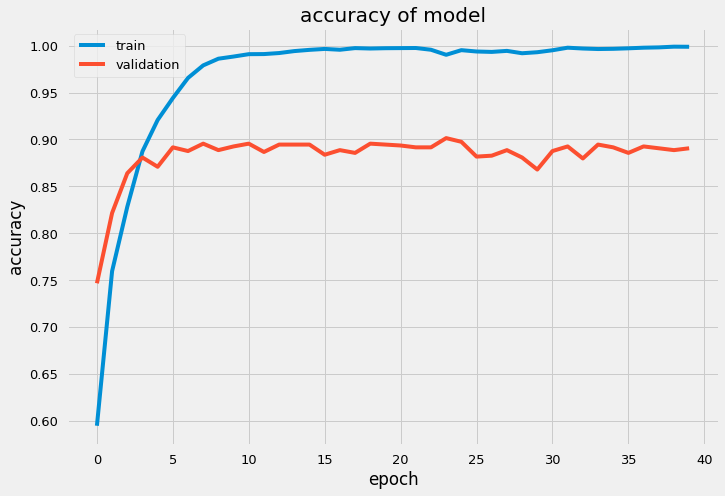

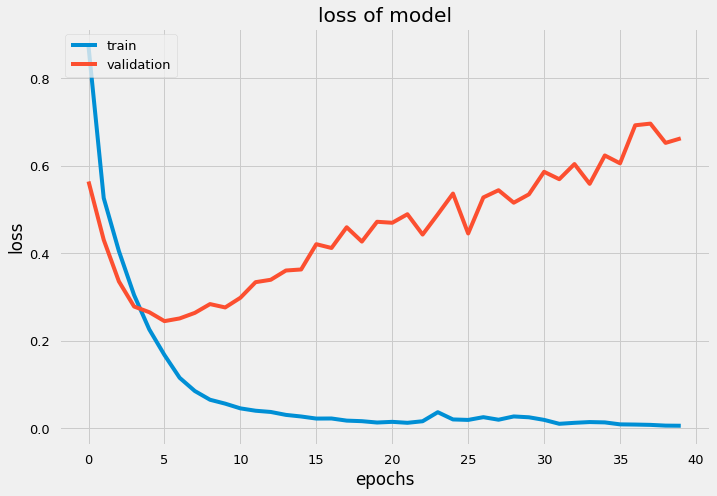

In [ ]:
plt.style.use('fivethirtyeight')

# plot of accuracy history for training of CNN
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy of model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# plot of loss history for training of CNN
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss of model')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#make prediction on test data using trained CNN
predictions = cnn_model.predict(cnn_testing_data, 
                            batch_size=300, 
                            verbose=0)
party_labels = ["Democrat", "Republican"]
prediction_parties=[]

for prediction in predictions:
    prediction_parties.append(party_labels[np.argmax(prediction)])

#present the result! 
print(test_data.Party.value_counts())
print("test accuracy: " + str(sum(test_data.Party==prediction_parties)/len(test_data)))
i = 0
demCorrect = 0
repCorrect = 0
for party in test_data.Party:
  if party == "Democrat":
    if prediction_parties[i] == "Democrat":
      demCorrect += 1
  elif party == "Republican":
    if prediction_parties[i] == "Republican":
      repCorrect += 1
  i += 1
print("Democrat tweets correctly guessed: " + str(demCorrect))
print("Republican tweets correctly guessed: " + str(repCorrect))


Democrat      1314
Republican    1219
Name: Party, dtype: int64
test accuracy: 0.8744571654165022
Democrat tweets correctly guessed: 1147
Republican tweets correctly guessed: 1068
